In [1]:
# HIDE CODE


import re
import os
import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

In [2]:
def plot_corr_hist(corr_list, labels, colors=None, cmap='tab10', figsize=(12, 8)):
    if colors is None:
        colors = list(sns.color_palette(cmap, n_colors=len(corr_list)))

    sns.set_style('whitegrid')
    plt.figure(figsize=figsize)
    for item, lbl, color in zip(corr_list, labels, colors):
        x = np.triu(item)
        x = x.flatten()
        sns.histplot(x[x>0.0], kde=True, color=color, alpha=0.25,
                     line_kws={'lw': 3}, label=lbl)
        mean = x[x>0.0].mean()
        plt.axvline(mean, color=color, ls='--', lw=1.5, label='{:s} mean: {:.3f}'.format(lbl, mean))

    plt.title('Histogram plot of correlations', fontsize=15, y=1.02)
    plt.legend(loc='upper left')
    plt.show()
    
    return



def filter_islands(partition, atlas, node_labels, min_com_size: int = 3):
    coms_ctr = collections.Counter(partition.values())
    
    good_com_idxs = zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common()))
    good_com_idxs = sorted(tuple(good_com_idxs)[0])
    bad_com_idxs = [item for item in set(partition.values()) if item not in good_com_idxs]

    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)
    comm_dict = dict(sorted(comm_dict.items()))

    comm_mat = np.ones(atlas.shape) * -1
    for node, com_idx in partition.items():
        region_id = node_labels[node]
        if com_idx in good_com_idxs:
            comm_mat[atlas == region_id] = good_com_idxs.index(com_idx)
        else:
            comm_mat[atlas == region_id] = np.nan
    
    output = {
        'good_com_idxs': good_com_idxs,
        'bad_com_idxs': bad_com_idxs,
        'comm_dict': comm_dict,
        'comm_mat': comm_mat,
    }
    return output


def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    pearson_th: float = 0.8,
    spearman_th: float = 0.7,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[pearson_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        im = axes[0, ii].imshow(output['comm_mat'], cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[spearman_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        im = axes[1, ii].imshow(output['comm_mat'], cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            axes[0, ii].set_ylabel('pearson\n(th = {:.2f})\n'.format(pearson_th), fontsize=12)
            axes[1, ii].set_ylabel('spearman\n(th = {:.2f})\n'.format(spearman_th), fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return

In [3]:
config = Config()

load = load_organized_data(
    folder='atlas-64_unfiltered_unnormalized',#'filtered_low-0.001_high-4.000_ord-2_normalized',
    config=config,
    subject=6,
    session=1,
    run=1,
)
load.keys()

dict_keys(['ca', 'atlas', 'ref', 'mask', 'atlas_kmeans', 'kmeans_centers', 'file_name'])

In [7]:
x = np.zeros(load['atlas_kmeans'].shape + (list(load['ca'].values())[0].shape[-1],))

for key, data in load['ca'].items():
    
    num_nan = np.isnan(load['ca'][key]).mean().sum()
    if num_nan > 0:
        print(key, num_nan)
        continue
    
    x[load['atlas_kmeans'] == key] = load['ca'][key]

x.shape

(190, 186, 5500)

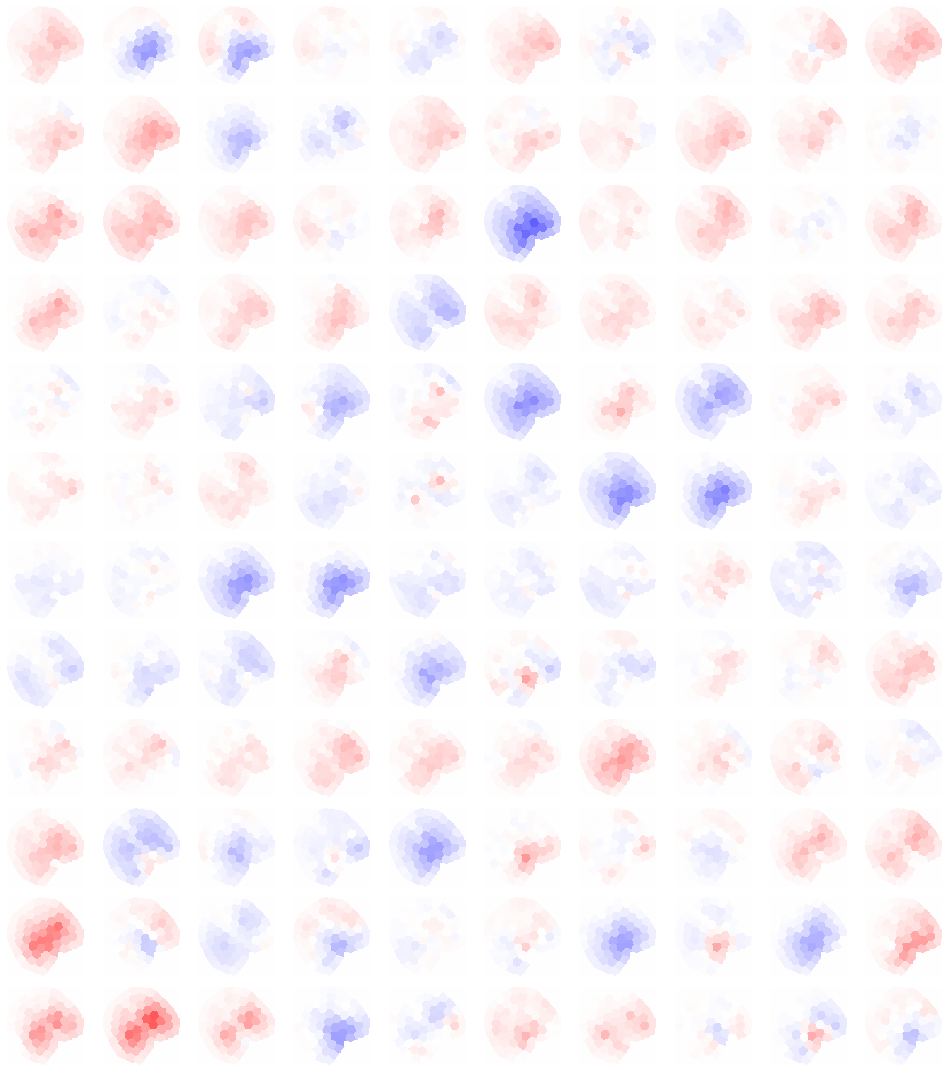

In [8]:
t = 1800
res = 10

_slice = x[..., t: t + res * 120]
vminmax = np.max(np.abs(_slice))

sns.set_style('white')
nrows, ncols = 12, 10
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 15))

for idx in range(_slice.shape[-1] // res):
    i, j = idx//ncols, idx%ncols
    axes[i, j].imshow(_slice[..., idx * res], vmin=-vminmax, vmax=vminmax, cmap='bwr', interpolation='none')
    axes[i, j].axis('off')
    
fig.tight_layout()
plt.show()

In [9]:
df = pd.DataFrame.from_dict(load['ca'])
node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

,1,2,3,4,5,6,7,8,9,10,...,55,56,57,58,59,60,61,62,63,64
count,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,...,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000,5500.000000
mean,8.220594,10.124248,15.034250,6.969628,17.044105,13.357854,6.497459,11.090709,21.173194,18.259820,...,22.123233,26.128471,10.736159,19.513757,14.947451,17.820791,9.485063,15.261226,10.043897,12.084008
std,27.121143,31.304852,41.860082,14.499889,60.249522,51.822411,10.833903,42.090334,85.319236,74.071770,...,117.898445,150.389381,37.717099,107.411174,84.717142,114.019217,35.886435,72.255902,55.356303,42.942090
min,-87.721245,-107.246559,-139.770491,-55.772785,-189.234563,-181.506035,-36.063888,-153.167702,-263.981409,-217.061803,...,-345.371132,-492.320324,-105.681839,-322.384564,-245.113290,-342.035546,-108.573831,-214.676619,-165.424433,-120.916012
25%,-8.693668,-10.032225,-12.242748,-1.227007,-22.738368,-19.780471,0.048693,-13.573963,-34.976604,-30.898511,...,-57.087448,-65.657050,-13.143469,-47.435103,-42.806067,-61.331070,-14.120381,-33.401682,-28.309800,-18.186438
50%,11.271709,11.817890,16.220909,8.697181,18.045251,19.373542,6.870322,17.220251,21.723419,18.539010,...,30.721276,51.724324,11.806106,38.524894,21.683746,34.192762,12.206589,24.965916,15.326576,16.770525
75%,26.997407,31.778222,43.051191,16.601593,57.301942,49.693927,13.454929,40.691540,79.851822,67.862504,...,104.195360,133.212233,36.385089,94.084055,76.854982,101.445738,35.487019,66.716823,50.779558,43.000844
max,94.673654,109.183853,169.818004,55.591359,215.579242,174.726620,46.424464,147.954006,324.269841,282.235511,...,461.399580,422.765423,138.272639,365.871480,263.197993,308.215484,115.056476,245.470028,161.853816,144.954251


In [11]:
thresholds = [0.75, 0.8, 0.85, 0.9, 0.95]
corrs = get_corrs(df, thresholds=thresholds)

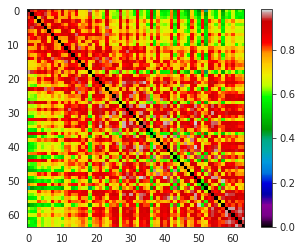

In [12]:
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral')
plt.colorbar()

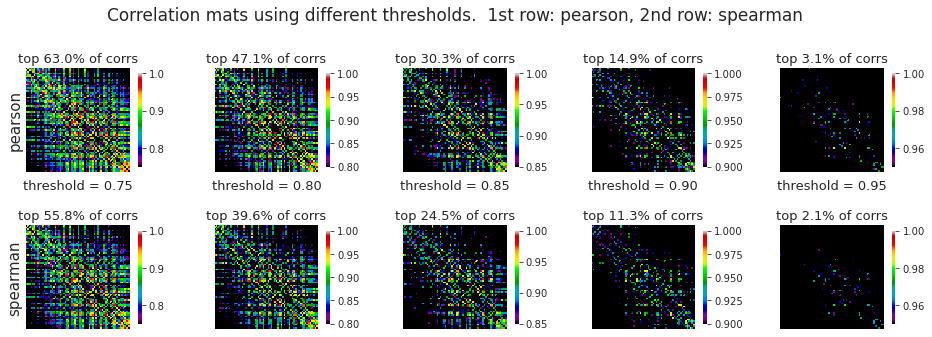

In [14]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'], thresholds)

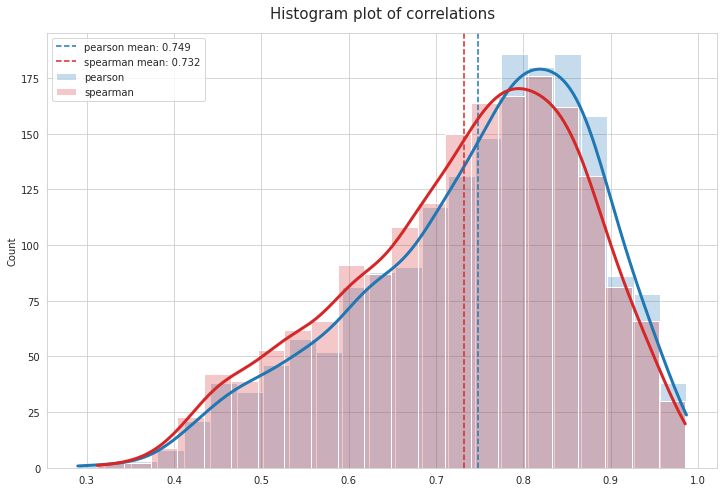

In [55]:
plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

In [56]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

In [57]:
results_louvain = run_louvain(graphs[0.8], res=np.logspace(-1, 1, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

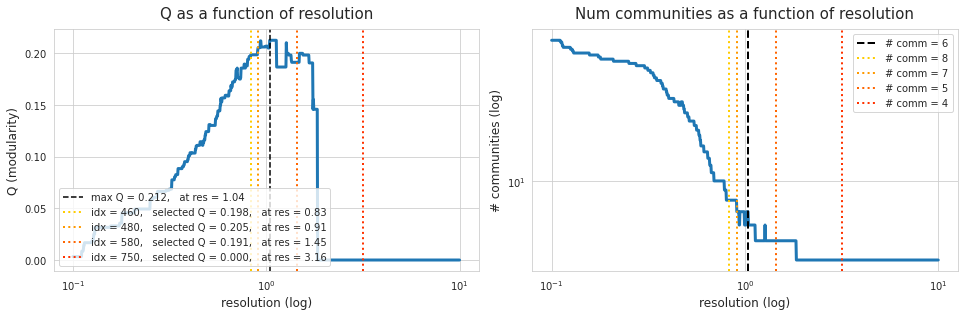

In [58]:
selected_idxs = [460, 480, 580, 750]
plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

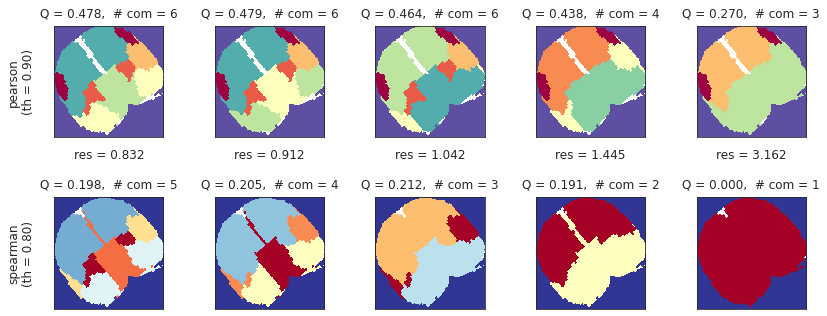

In [59]:
plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.9,
    spearman_th=0.8,
    figsize=(12, 4.5),
    colorbar=False, )

### Concanenate

In [61]:
data = {}
for run in [1, 3, 5, 7]:
    load = load_organized_data(
        folder='unfiltered_unnormalized',#'filtered_low-0.001_high-4.000_ord-2_normalized',
        config=config,
        subject=6,
        session=1,
        run=run,
    )
    data[run] = load

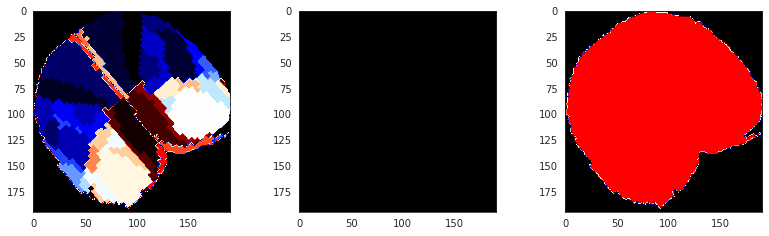

In [62]:
plt.figure(figsize=(13.5, 3.7))

plt.subplot(131)
plt.imshow(data[1]['atlas'], cmap='flag_r')

plt.subplot(132)
plt.imshow(data[1]['atlas'] == 222, cmap='flag_r')

plt.subplot(133)
plt.imshow((data[1]['atlas'] != 222) & (load['atlas'] > 0), cmap='flag_r')

plt.show()

In [63]:
for run in [1, 3, 5, 7]:
    print(run, len(data[run]['ca']), len(np.unique(data[run]['atlas'])))

1 61 64
3 61 64
5 61 64
7 61 64


In [64]:
for run in [1, 3, 5, 7]:
    print(run, set(np.unique(data[run]['atlas'])).difference(set(data[run]['ca'].keys())))

1 {0, 33, 41}
3 {0, 33, 41}
5 {0, 33, 41}
7 {0, 33, 41}


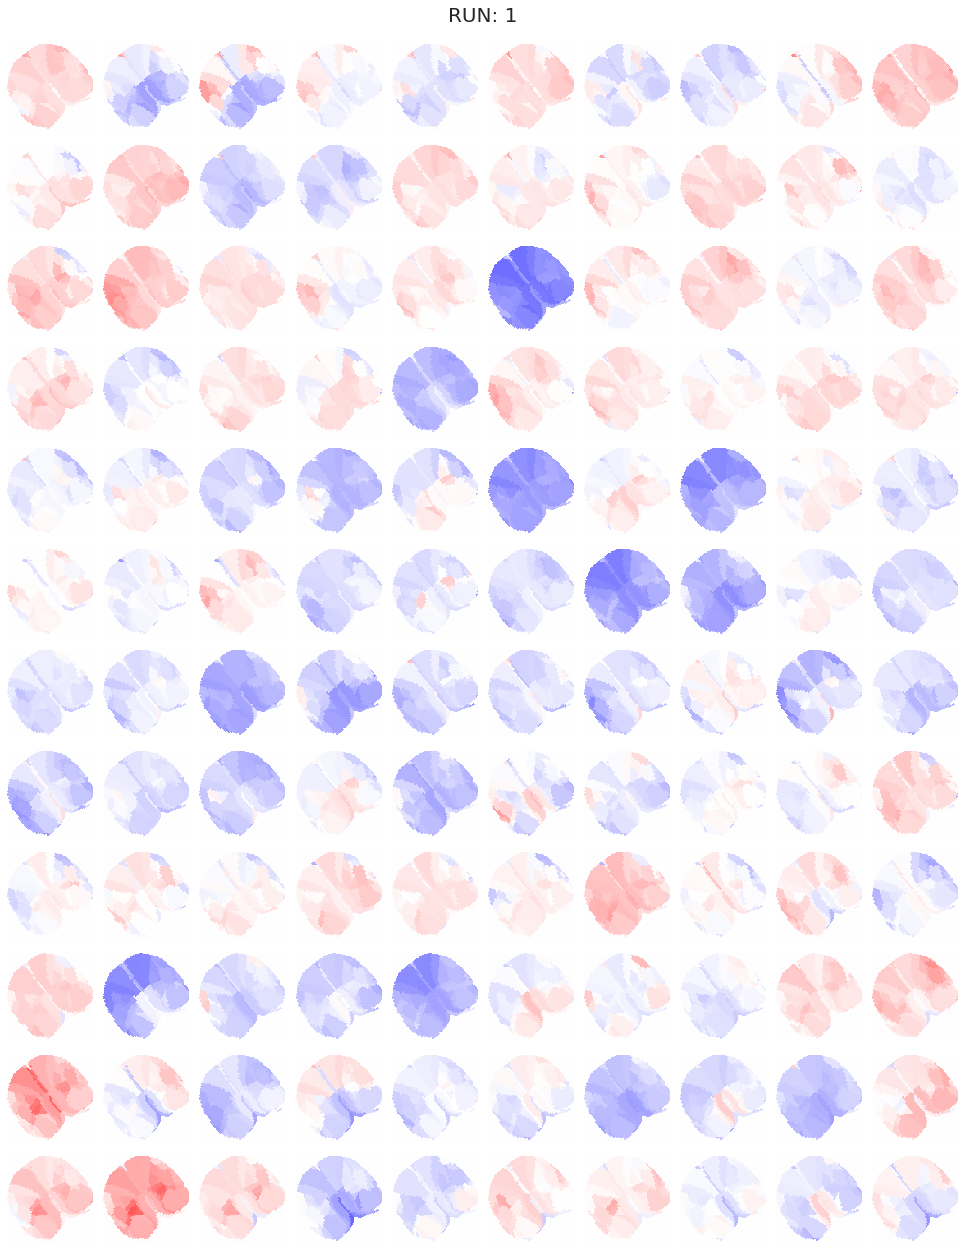

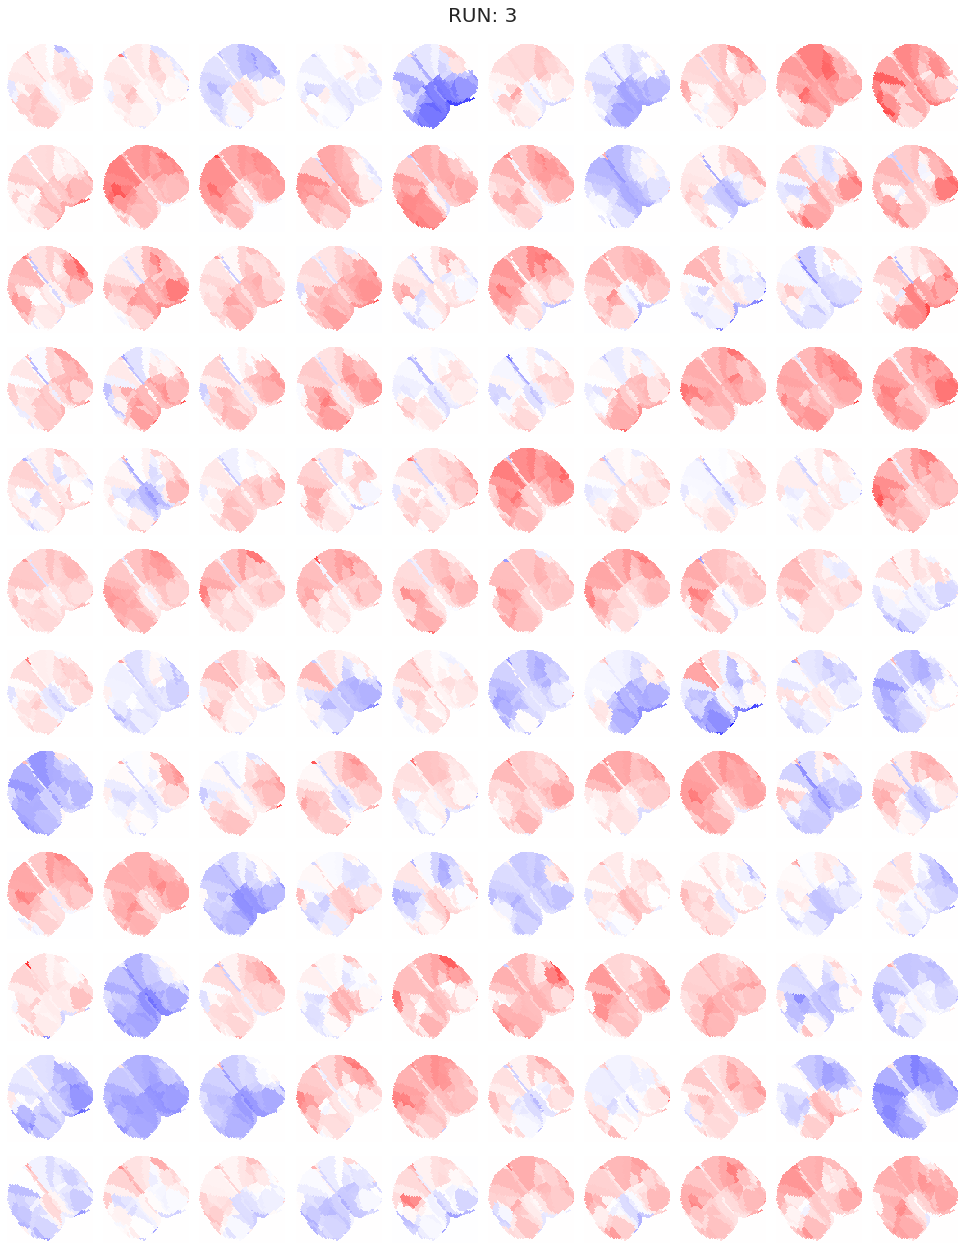

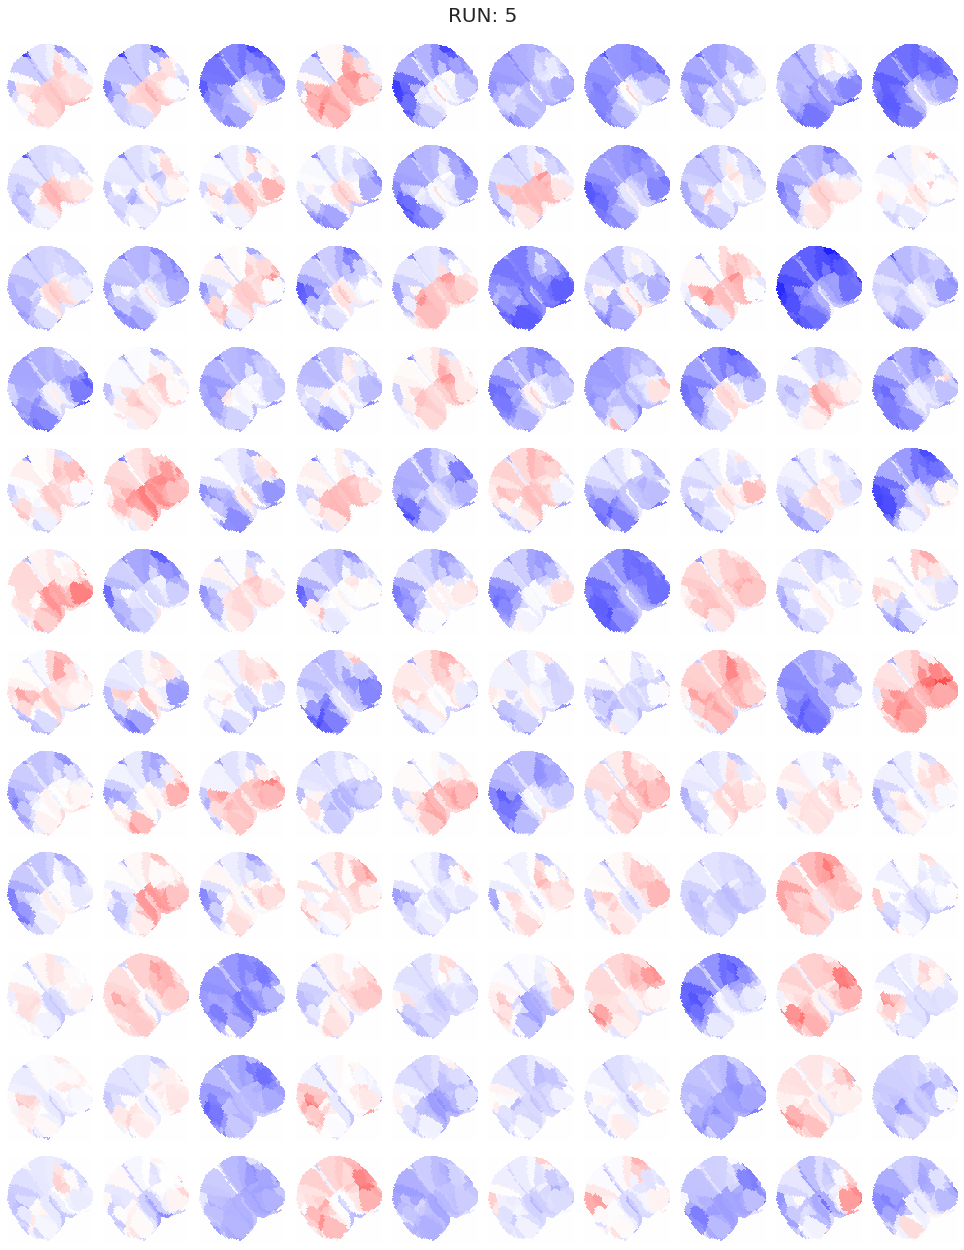

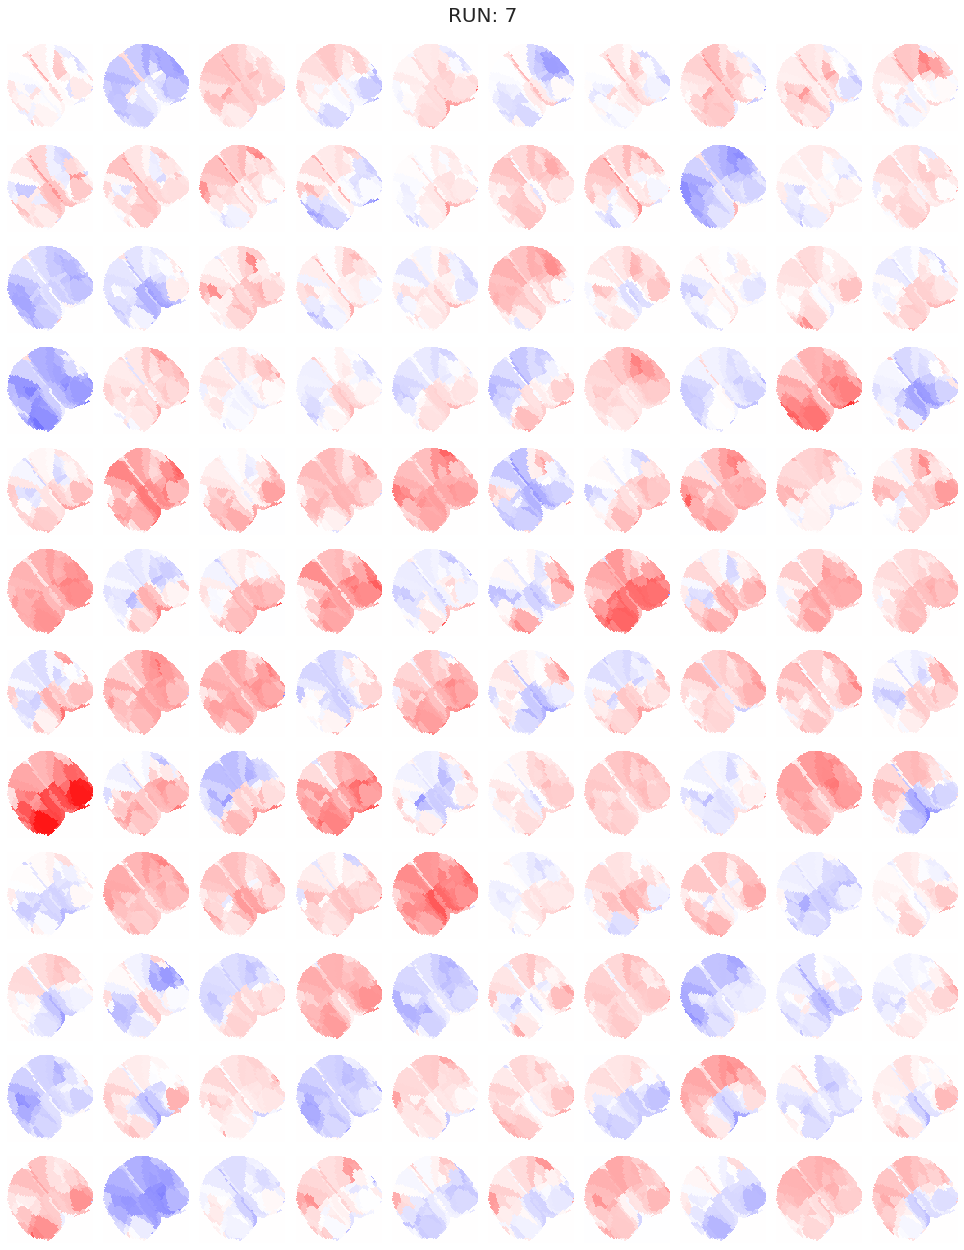

In [65]:
for run in [1, 3, 5, 7]:
    x = np.zeros(data[run]['atlas'].shape + (list(data[run]['ca'].values())[0].shape[-1],))

    for key, time_series in data[run]['ca'].items():
        num_nan = np.isnan(time_series).sum()
        if num_nan > 0:
            print(key, num_nan)
            continue

        x[data[run]['atlas'] == key] = data[run]['ca'][key]
        
    t = 1800
    res = 10

    _slice = x[..., t: t + res * 120]
    vminmax = np.max(np.abs(_slice))

    sns.set_style('white')
    nrows, ncols = 12, 10
    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 17))

    for idx in range(_slice.shape[-1] // res):
        i, j = idx//ncols, idx%ncols
        axes[i, j].imshow(_slice[..., idx * res], vmin=-vminmax, vmax=vminmax, cmap='bwr', interpolation='none')
        axes[i, j].axis('off')

    fig.tight_layout()
    fig.suptitle('RUN: {:d}'.format(run), fontsize=20, y=1.02)
    plt.show()
    
    print('\n\n')

In [66]:
df = pd.DataFrame()

for run, load in data.items():
    df = pd.concat([df, pd.DataFrame.from_dict(data[run]['ca'])])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

,2,3,4,5,6,7,8,9,10,11,...,525,526,528,530,538,539,540,541,655,656
count,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,...,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04,2.200000e+04
mean,-7.943267e-17,-1.449355e-16,-6.362461e-17,-3.705622e-17,-1.000008e-16,1.240573e-16,-4.768913e-17,1.179006e-16,-1.479435e-16,-6.551830e-17,...,1.660288e-16,8.529036e-17,4.727380e-16,-4.568050e-16,5.796720e-17,1.352532e-16,-8.520489e-17,2.967462e-16,4.336430e-17,-1.119054e-17
std,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,...,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00,1.000023e+00
min,-3.712641e+00,-4.161112e+00,-3.404397e+00,-3.527629e+00,-3.159035e+00,-3.753092e+00,-3.332686e+00,-3.019642e+00,-3.482042e+00,-3.225162e+00,...,-3.855143e+00,-3.363150e+00,-4.359220e+00,-3.534192e+00,-3.697468e+00,-3.469518e+00,-3.832680e+00,-3.742846e+00,-3.305037e+00,-3.806465e+00
25%,-6.618210e-01,-6.434595e-01,-6.906074e-01,-6.893152e-01,-6.730613e-01,-6.816163e-01,-6.774442e-01,-6.859514e-01,-6.867057e-01,-6.950612e-01,...,-6.664093e-01,-6.896908e-01,-6.182442e-01,-6.060943e-01,-5.962133e-01,-6.138134e-01,-6.408468e-01,-6.720892e-01,-6.356774e-01,-6.391822e-01
50%,4.015162e-03,-4.526041e-03,-2.959994e-02,-2.124880e-02,-2.964608e-02,-1.480387e-02,-2.251929e-02,-3.895739e-02,-2.070966e-02,-2.652678e-02,...,-2.609249e-04,-1.625262e-02,-4.128218e-02,-1.788177e-02,4.195114e-02,4.422220e-02,1.425671e-02,3.422303e-03,-3.801255e-03,-1.570662e-02
75%,6.557064e-01,6.314881e-01,6.478796e-01,6.573737e-01,6.538920e-01,6.584215e-01,6.610954e-01,6.447057e-01,6.634648e-01,6.541951e-01,...,6.548101e-01,6.586565e-01,5.725076e-01,5.908924e-01,6.449206e-01,6.296736e-01,6.117628e-01,6.694277e-01,6.021262e-01,6.011782e-01
max,6.116167e+00,6.731212e+00,5.037860e+00,5.469960e+00,6.325484e+00,4.446328e+00,5.256533e+00,5.680413e+00,5.595429e+00,5.757475e+00,...,5.388754e+00,5.832130e+00,1.167115e+01,5.940249e+00,7.401193e+00,7.377751e+00,9.111155e+00,4.861781e+00,1.174976e+01,9.733645e+00


In [67]:
22000 / 4

5500.0

In [68]:
thresholds = [0.6, 0.75, 0.8, 0.85, 0.9]
corrs = get_corrs(df, thresholds=thresholds)

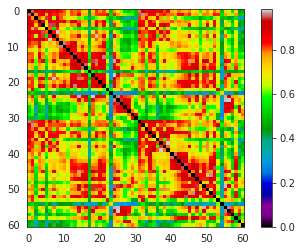

In [69]:
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral')
plt.colorbar()

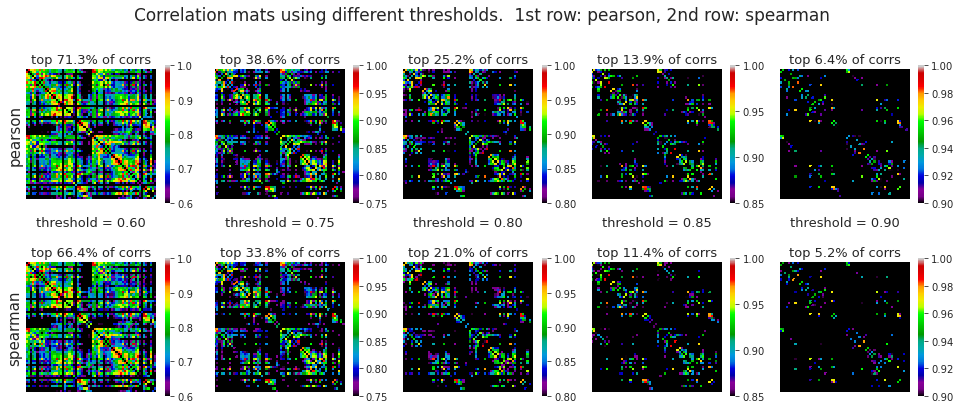

In [70]:
plot_corrs(corrs['pearson'], corrs['spearman'], thresholds)

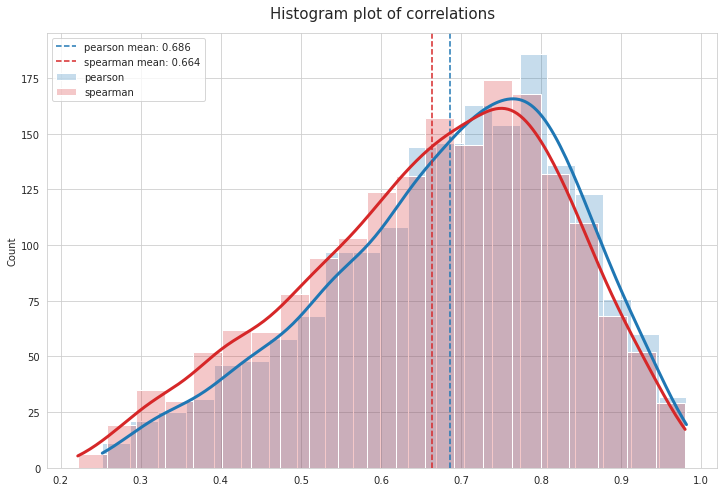

In [71]:
plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

In [72]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

In [73]:
results_louvain = run_louvain(graphs[0.85], res=np.logspace(-1, 1, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

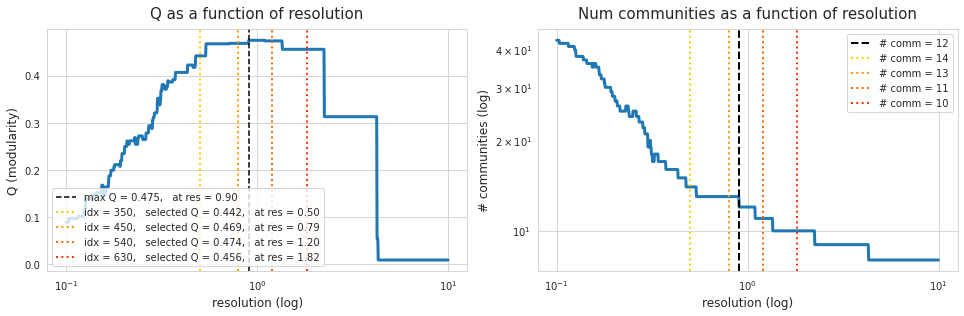

In [74]:
selected_idxs = [350, 450, 540, 630]
plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

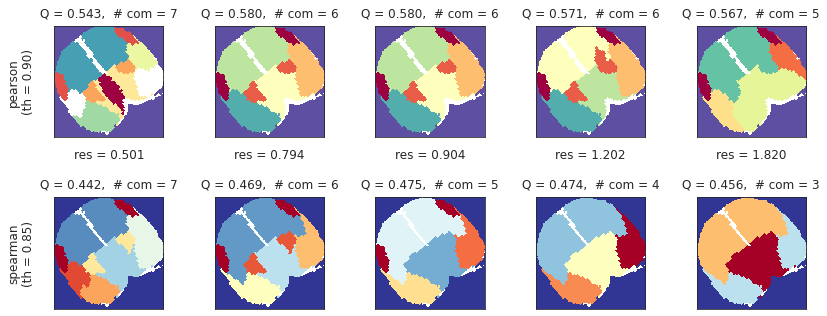

In [75]:
plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.9,
    spearman_th=0.85,
    figsize=(12, 4.5),
    colorbar=False, )

### Network measures

In [118]:
field_names = ('subject', 'session', 'run', 'threshold', 'node_labels', 'adjacency', 'graph', 'cfg')

Data = collections.namedtuple(
    typename='Data',
    field_names=field_names,
)

In [119]:
config = Config()
thresholds = [0.70, 0.75, 0.80, 0.85, 0.90]

data_all = {}
for subject in tqdm(range(1, config.num_subjects + 1)):
    for session in tqdm(range(1, config.num_sessions + 1), leave=False):
        for run in range(1, config.num_runs + 1):

            load = load_organized_data(
                folder='unfiltered_normalized',
                config=config,
                subject=subject,
                session=session,
                run=run,
            )
            
            if load is None:
                continue
            
            df = pd.DataFrame.from_dict(load['ca'])
            node_labels = df.columns.values.tolist()
            node_labels = {i: lbl for i, lbl in enumerate(node_labels)}
            corrs = get_corrs(df, thresholds=thresholds)

            key = 'sub-SLC{:02d}'.format(subject)
            key += '_ses-{:d}'.format(session)
            key += '_run-{:d}'.format(run)
            
            for th in thresholds:
                a = corrs['spearman'][th]
                g = nx.from_numpy_matrix(a)
                
                data_all['{:s}_th-{:.2f}'.format(key, th)] = Data(
                    subject=subject,
                    session=session,
                    run=run,
                    threshold=th,
                    node_labels=node_labels,
                    adjacency=a,
                    graph=g,
                    cfg=mk_config_model(g, weighted=True),
                )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Warning! File not found, moving on . . .
['sub-SLC03', 'ses-1', 'run-1', 'organized', 'ca']



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Warning! File not found, moving on . . .
['sub-SLC05', 'ses-1', 'run-5', 'organized', 'ca']



  0%|          | 0/3 [00:00<?, ?it/s]

Warning! File not found, moving on . . .
['sub-SLC06', 'ses-3', 'run-2', 'organized', 'ca']



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Warning! File not found, moving on . . .
['sub-SLC08', 'ses-1', 'run-7', 'organized', 'ca']



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Warning! File not found, moving on . . .
['sub-SLC10', 'ses-3', 'run-1', 'organized', 'ca']



In [120]:
# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length

In [162]:
measures_df = pd.DataFrame()

dict_list = []
for k, data in tqdm(data_all.items()):
    # nodes, degrees = list(zip(*g.degree()))
    
    num_nodes = len(data.node_labels)
    
    # the real graph
    _avg_clustering = average_clustering(data.graph, weight='weight')
    _local_efficiency = local_efficiency(data.graph)
    _large_clique_ratio = large_clique_size(data.graph) / num_nodes
    try:
        _avg_shortest_path_len = average_shortest_path_length(data.graph, weight='weight')
    except:
        _avg_shortest_path_len = np.nan
    _global_efficiency = global_efficiency(data.graph)
    _degree_corr_coef = degree_pearson_correlation_coefficient(data.graph, weight='weight')

    data_dict = {
        'tag': ['real'] * 6,
        'subject': [data.subject] * 6,
        'session': [data.session] * 6,
        'run': [data.run] * 6,
        'threshold': [data.threshold] * 6,
        'num_regions': [num_nodes] * 6,
        'lbl': [
            'avg_clustering',
            'local_efficiency',
            'large_clique_ratio',
            'avg_shortest_path_len',
            'global_efficiency',
            'degree_corr_coef',  # assortativity
        ],
        'val': [
            _avg_clustering,
            _local_efficiency,
            _large_clique_ratio,
            _avg_shortest_path_len,
            _global_efficiency,
            _degree_corr_coef,
        ],
    }
    dict_list.append(data_dict)
    

    # configuration model
    _avg_clustering = average_clustering(data.cfg, weight='weight')
    _local_efficiency = local_efficiency(data.cfg)
    _large_clique_ratio = large_clique_size(data.cfg) / num_nodes
    try:
        _avg_shortest_path_len = average_shortest_path_length(data.cfg, weight='weight')
    except:
        _avg_shortest_path_len = np.nan
    _global_efficiency = global_efficiency(data.cfg)
    _degree_corr_coef = degree_pearson_correlation_coefficient(data.cfg, weight='weight')

    data_dict = {
        'tag': ['cfg'] * 6,
        'subject': [data.subject] * 6,
        'session': [data.session] * 6,
        'run': [data.run] * 6,
        'threshold': [data.threshold] * 6,
        'num_regions': [num_nodes] * 6,
        'lbl': [
            'avg_clustering',
            'local_efficiency',
            'large_clique_ratio',
            'avg_shortest_path_len',
            'global_efficiency',
            'degree_corr_coef',  # assortativity
        ],
        'val': [
            _avg_clustering,
            _local_efficiency,
            _large_clique_ratio,
            _avg_shortest_path_len,
            _global_efficiency,
            _degree_corr_coef,
        ],
    }
    dict_list.append(data_dict)

measures_df = pd.DataFrame.from_dict(merge_dicts(dict_list))

  0%|          | 0/1025 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [163]:
measures_df

,tag,subject,session,run,threshold,num_regions,lbl,val
0,real,1,1,1,0.7,66,avg_clustering,0.609992
1,real,1,1,1,0.7,66,local_efficiency,0.839339
2,real,1,1,1,0.7,66,large_clique_ratio,0.378788
3,real,1,1,1,0.7,66,avg_shortest_path_len,NaN
4,real,1,1,1,0.7,66,global_efficiency,0.699184
...,...,...,...,...,...,...,...,...
12295,cfg,10,3,7,0.9,62,local_efficiency,0.066340
12296,cfg,10,3,7,0.9,62,large_clique_ratio,0.048387
12297,cfg,10,3,7,0.9,62,avg_shortest_path_len,NaN
12298,cfg,10,3,7,0.9,62,global_efficiency,0.207673


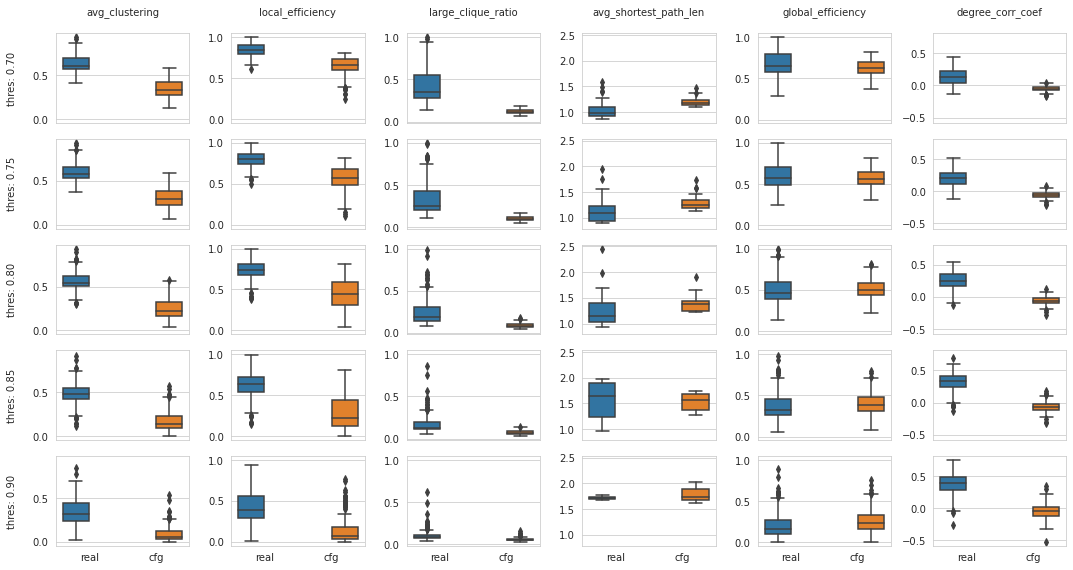

In [164]:
_ths = measures_df.threshold.unique().tolist()
_lbls = measures_df.lbl.unique().tolist()

sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=len(_ths), ncols=len(_lbls), figsize=(15, 8), sharey='col', sharex='all')

for i, th in enumerate(_ths):
    for j, lbl in enumerate(_lbls):
        selected_df = measures_df.loc[(measures_df.threshold == th) & (measures_df.lbl == lbl)]
        sns.boxplot(data=selected_df, y='val', x='tag', hue='tag', ax=axes[i, j])
        axes[i, j].legend().set_visible(False)
        axes[i, j].set_xlabel('')
        
        if i == 0:
            axes[i, j].set_title('{:s}\n'.format(lbl), fontsize=10)
            
        if j == 0:
            axes[i, j].set_ylabel('thres: {:.2f}\n'.format(th), fontsize=10)
        else:
            axes[i, j].set_ylabel('')

fig.savefig('net_measures.pdf', dpi=200)
fig.tight_layout()
plt.show()

In [ ]:
# TODO: make this general

def plot_louvain_communities(
    graphs: list,
    # pearson: dict,
    # spearman: dict,
    atlas: np.ndarray,
    # modularities: dict,
    # selected_idxs: list,
    # pearson_th: float = 0.7,
    # spearman_th: float = 0.8,
    figsize=(12, 4.5),
    colorbar=False, ):

    # x0, y0 = tuple(zip(*modularities.items()))
    # best_idx = np.argmax(y0)
    # max_mod = y0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # g = nx.from_numpy_matrix(spearman[spearman_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=best_idx[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        # comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=coms.communities)

        im = axes[0, ii].imshow(output['comm_mat'], cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[0, ii].set_title(msg, y=1.03)

        g = nx.from_numpy_matrix(pearson[0.8])
        partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[1, ii].imshow(comm_mat, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[1, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[0, ii].set_ylabel('spearman\n(th = {:.2f})\n'.format(spearman_th), fontsize=12)
            axes[1, ii].set_ylabel('pearson\n(th = {:.2f})\n'.format(pearson_th), fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()

    return